# Training Data Collection and EDA

In order to develop a NLP model which can predict whether a tweet is referring to a recent, local case of covid-19, we scrapped twitter for ~5,000 posts from March, 2020 that contained the phrase "tested positive." We then manually assigned these tweets as a positive (1) or negative (0). Proper names were removed from tweets to preserve anonymity of posts.

In [1]:
# Import relevant libraries

import pandas as pd
import json
import pyodbc
import shutil
import spacy
import os
import p5_functions as pf
from scrapy import cmdline
from datetime import datetime, timedelta
from os import walk

# Data Collection


##### This code scrapes 300 "tested positive" tweets every two days starting March 1, 2020, over 30 days in order to generate a training data set of ~4,500 tweets. This code should not be run again - to load training and location data, use the csv files included in this repo.

```
training_df = pd.DataFrame(columns=['user', 'tweet', 'date'])
date = '2020-03-01'
for x in range(15):
    next_day = (datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
    os.system('scrapy crawl TweetScraper -a query="tested positive since:' + date + ' until:' + next_day + '" -a lang="en"')
    day_tweets = pf.create_tweetdf(users=True)
    day_tweets['date'] = date
    training_df = training_df.append(day_tweets, ignore_index=True)
    print('Scraped 300 tweets from date: ' + date)
    date = (datetime.strptime(next_day, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
```

~~~
# For each unique user in the training data, scrape their profile page for their location if they included that information. Search for both city and state - if the function detects that the user is located outside of the United States, sets state column to 'foreign' and leaves city blank. Drop username for privacy and save to csv

unique_users = list(set(training_df['user']))
user_dict = {'city':[], 'state':[]}
for user in unique_users:
    city, state, raw = pf.profile_loc(user)
    user_dict['city'].append(city)
    user_dict['state'].append(state)
user_df = pd.DataFrame.from_dict(user_dict)
user_df.to_csv('../data/user_loc.csv', index=False)
~~~

~~~
# For all tweets in the training data set, drop the user column and replace all proper nouns with PROPN for privacy concerns. Save to csv for manual labeling

training_df.drop_duplicates(subset='tweet')
training_df['tweet'] = [pf.sterilize(x) for x in training_df['tweet']]
training_df.drop('user', axis=1, inplace=True)
training_df.to_csv('../data/redacted_training.csv', index=False)
~~~

##### Since no labeled data exists for our particular problem, we manually labeled tweets ourselves for whether a message was referring to a recent, local case of covid-19. Positives were labeled as 1 and recorded in the csv file. This final csv was then uploaded to the SQL server for future reference, if needed

~~~
# Read labeled csv file, upload to SQL server under table name ct_training_data

training_df = pd.read_csv('../data/redacted_training.csv')
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=ga-cc12-s5.database.windows.net;DATABASE=ga_p5;UID=ga;PWD=[REDACTED]')
cursor = cnxn.cursor()
cursor.execute('CREATE TABLE ct_training_data (tweet varchar(1023), label int)')
for index, row in training_df.iterrows():
    cursor.execute("INSERT INTO ct_training_data (tweet, label) values(?,?)", row['tweet'], row['label'])
cnxn.commit()
cursor.close()
~~~

# EDA

##### For the purposes of our problem, we were interested in two things: a user's location, and whether a tweet was relevant to mapping incidences of covid-19. Unfortunately, due to the nature of social media, and twitter in particular, creating a robust training data set from the available information was not possible. For geolocation, very few users choose to include their place of residence in their profile. For both city and state, more than 60% of users do not have relevant information pertaining to their location

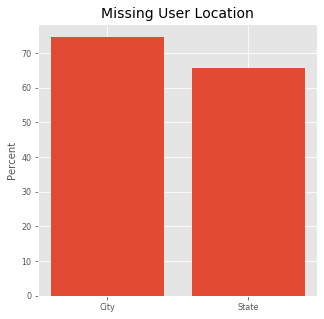

Number of Users: 4158


In [2]:
df = pd.read_csv('../data/user_loc.csv')
df.isna().mean()*100
pf.create_bar(df[['city','state']].isna().mean()*100, 'Missing User Location', ylabel='Percent', ticks=['City','State'], size=(5,5))
print(f'Number of Users: {len(df)}')

##### In addition, most tweets mentioning testing positive are not referring to nearby cases, but are often in reference to news stories, celebrities, politics, or memes. From our manual labeling, only about 5% of the tweets were useful for our purposes

In [10]:
df = pd.read_csv('../data/redacted_training.csv')
df.fillna(0, inplace=True)
print(f'Number of Tweets: {len(df)}\nPercent Positive: {round(df["label"].mean()*100, 2)}')

Number of Tweets: 4481
Percent Positive: 5.53
